---



# <font color='#33ffa3'>**Análisis Multimodal de Síntomas en la Enfermedad de Parkinson**</font>

In [3]:
#@title **Importar librerías**

# Manipulación de datos
import os
import cv2
import numpy as np
import pandas as pd
from zipfile import ZipFile


# Utils
import matplotlib.pyplot as plt


# sklearn
from sklearn.model_selection import GroupKFold
from sklearn.decomposition import PCA

In [4]:
#@title **Cargamos los datos desde Drive**

from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/data_parkinson')
print(os.getcwd())

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1XRruCPRodR4OhRCRZYKsyODqa_GuBkfC/data_parkinson


In [5]:
#@title **Extraer el zip**

os.mkdir('../../../../data')
os.popen('cp data.csv ../../../../data/data.csv')
target_path = os.path.join('../../../../data') # Aquí es donde van a quedar los datos
# deben quedar fuera de drive para poder acceder a ellos 'localmente'

# Unzip the downloaded files
zip_file_path = os.path.join('AudioVisualData_v7.zip')
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_path)

# # Me muevo hasta donde quedaron los datos
%cd ../../../../data
# Verifico
%ls

/content/data
AudioVisualData_v7/  data.csv


# <font color='#33ffe7'>**1. Procesamiento del dataset**</font>

## <font color='#52F17F'>**Creación del Dataset Pandas auxiliar**</font>

In [6]:
data = pd.read_csv("data.csv", index_col='patient')

def string2array(string: str):
  """ Convierte un string con datos a numpy array """
  string = string.strip('[]')
  return np.fromstring(string, sep=',')

data['flatten_log_mel_spectogram'] = data['flatten_log_mel_spectogram'].apply(string2array)
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram
patient,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24...."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26...."


In [7]:
"""
Constante sacada de la media de cantidad de frames de todos los vídeos multiplicada por 0.1
para tener el 10%
"""

FRAMES_PROMEDIO = 14

def preprocess_frame(frame_path: str):
  frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE) # Leemos la imagen desde la ruta en escala de grises
  # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # La pasamos de BGR a RGB
  frame = cv2.resize(frame, (112, 112)) # Resize a 112x112
  frame = frame / 255. # Normalizamos entre 0 y 1
  return frame.flatten()
  # return frame

def preprocess_video(video_path: str, n_frames = FRAMES_PROMEDIO):
  frames = []
  for frame in sorted(os.listdir(video_path))[:n_frames]:
    frames.append(preprocess_frame(f"{video_path}/{frame}"))
  return np.concatenate(frames)
  # return frames

# Preprocesar todos los audios y almacenar los espectrogramas mel
data['flatten_frame_sequence'] = data['frames_path'].apply(preprocess_video)

# Verificar los datos
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram,flatten_frame_sequence
patient,,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24....","[0.44313725490196076, 0.4470588235294118, 0.44..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8...","[0.4627450980392157, 0.4627450980392157, 0.458..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28...","[0.4666666666666667, 0.4666666666666667, 0.474..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20...","[0.44313725490196076, 0.44313725490196076, 0.4..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26....","[0.4627450980392157, 0.45098039215686275, 0.45..."


In [8]:
def preprocess_and_fuse(flatten_frame_sequence, flatten_log_mel_spectogram):
    """
    Esta función concatena los frames aplanados y el espectrograma mel aplanado.

    Args:
        flatten_frame_sequence: array de frames aplanados.
        flatten_log_mel_spectogram: array de espectrograma mel aplanado.

    Returns:
        fused_features: Un array que contiene la concatenación de los frames y el espectrograma mel.
    """
    # Concatenar los frames y el espectrograma mel
    return np.concatenate([flatten_frame_sequence, flatten_log_mel_spectogram])

In [9]:
# Fusionar todas las características aplanadas
data['fused_flattened_features'] = data.apply(
    lambda row: preprocess_and_fuse(row['flatten_frame_sequence'], row['flatten_log_mel_spectogram']),
    axis=1
)

# Verificar los datos
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram,flatten_frame_sequence,fused_flattened_features
patient,,,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24....","[0.44313725490196076, 0.4470588235294118, 0.44...","[0.44313725490196076, 0.4470588235294118, 0.44..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8...","[0.4627450980392157, 0.4627450980392157, 0.458...","[0.4627450980392157, 0.4627450980392157, 0.458..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28...","[0.4666666666666667, 0.4666666666666667, 0.474...","[0.4666666666666667, 0.4666666666666667, 0.474..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20...","[0.44313725490196076, 0.44313725490196076, 0.4...","[0.44313725490196076, 0.44313725490196076, 0.4..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26....","[0.4627450980392157, 0.45098039215686275, 0.45...","[0.4627450980392157, 0.45098039215686275, 0.45..."


## <font color='#52F17F'>**PCA Analysis**</font>

### <font color='#EB9A54'>**Hipomimia**</font>

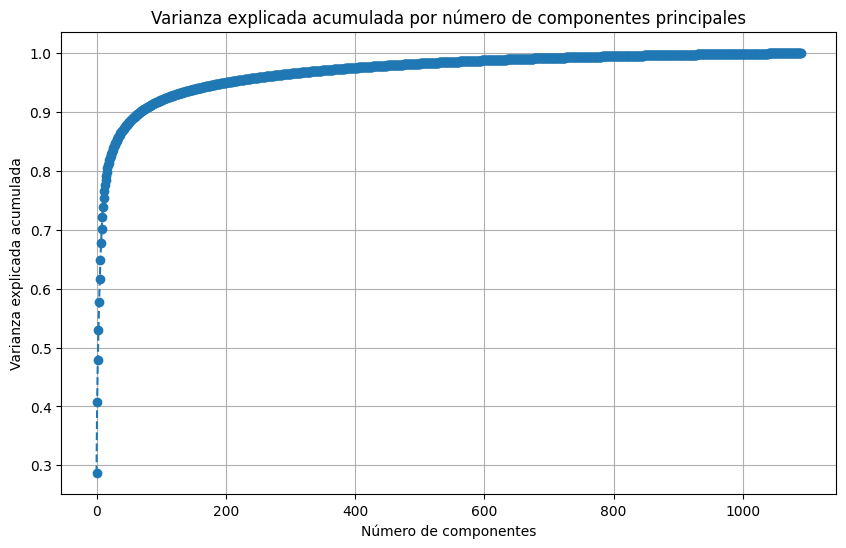

Número de componentes para retener el 90% de la varianza: 69
Número de componentes para retener el 95% de la varianza: 200
Número de componentes para retener el 99% de la varianza: 652


In [10]:
pca_video = PCA()
pca_video.fit(np.vstack(data['flatten_frame_sequence']))

# Varianza explicada acumulada
explained_variance_ratio = np.cumsum(pca_video.explained_variance_ratio_)

# Graficar la varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada acumulada por número de componentes principales')
plt.grid(True)
plt.show()

# Imprimir el número de componentes para diferentes niveles de varianza explicada
thresholds = [0.90, 0.95, 0.99]
for threshold in thresholds:
    num_components = np.argmax(explained_variance_ratio >= threshold) + 1
    print(f'Número de componentes para retener el {int(threshold*100)}% de la varianza: {num_components}')

### <font color='#EB9A54'>**Disartria**</font>

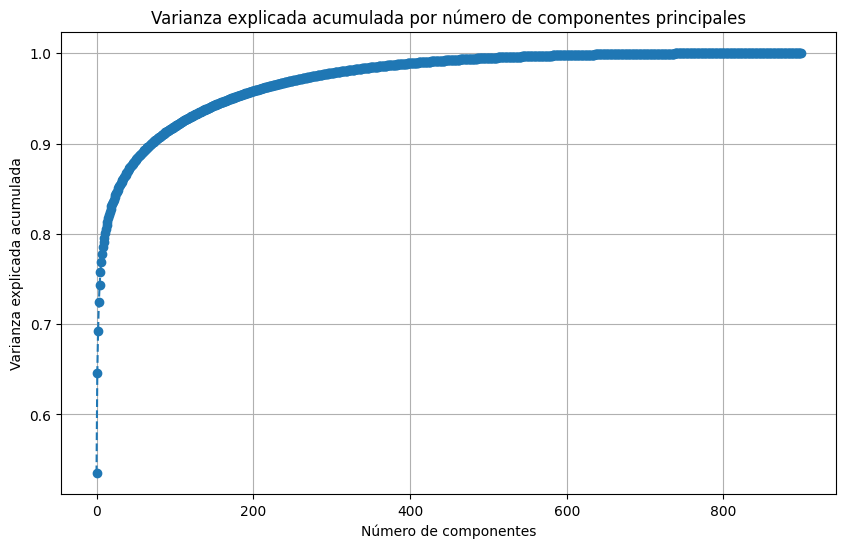

Número de componentes para retener el 90% de la varianza: 72
Número de componentes para retener el 95% de la varianza: 174
Número de componentes para retener el 99% de la varianza: 416


In [11]:
pca_audio = PCA()
pca_audio.fit(np.vstack(data['flatten_log_mel_spectogram']))

# Varianza explicada acumulada
explained_variance_ratio = np.cumsum(pca_audio.explained_variance_ratio_)

# Graficar la varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada acumulada por número de componentes principales')
plt.grid(True)
plt.show()

# Imprimir el número de componentes para diferentes niveles de varianza explicada
thresholds = [0.90, 0.95, 0.99]
for threshold in thresholds:
    num_components = np.argmax(explained_variance_ratio >= threshold) + 1
    print(f'Número de componentes para retener el {int(threshold*100)}% de la varianza: {num_components}')

### <font color='#EB9A54'>**Análisis multimodal**</font>

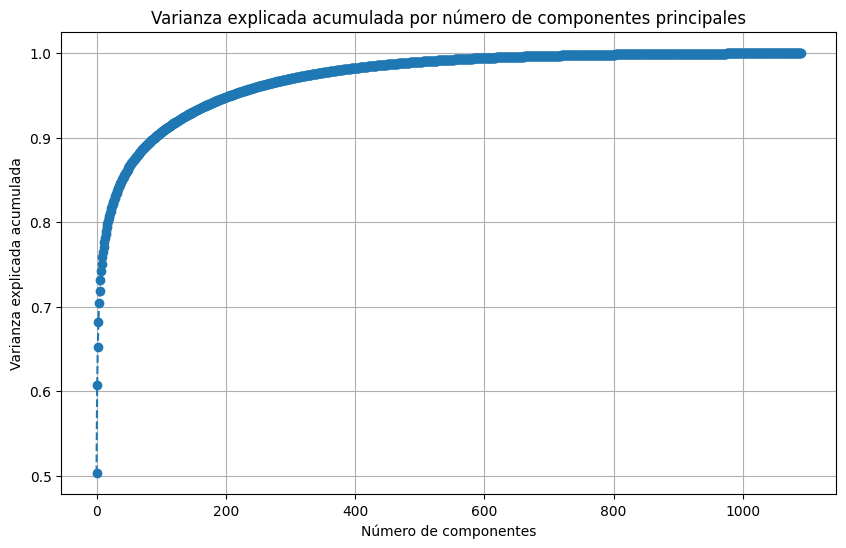

Número de componentes para retener el 90% de la varianza: 91
Número de componentes para retener el 95% de la varianza: 208
Número de componentes para retener el 99% de la varianza: 503


In [12]:
pca_fused_feat = PCA()
pca_fused_feat.fit(np.vstack(data['fused_flattened_features']))

# Varianza explicada acumulada
explained_variance_ratio = np.cumsum(pca_fused_feat.explained_variance_ratio_)

# Graficar la varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada acumulada por número de componentes principales')
plt.grid(True)
plt.show()

# Imprimir el número de componentes para diferentes niveles de varianza explicada
thresholds = [0.90, 0.95, 0.99]
for threshold in thresholds:
    num_components = np.argmax(explained_variance_ratio >= threshold) + 1
    print(f'Número de componentes para retener el {int(threshold*100)}% de la varianza: {num_components}')

# <font color='#33e4ff'> **2. Machine Learning 🦾**</color> <a name="tema8">

In [13]:
# Sklearn for datasets.
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold

# Sklearn metrics.
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score)

# Sklearn models
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [14]:
models = [
    ('GNB', GaussianNB()),
    ('DT DEFAULT', DecisionTreeClassifier()),
    ('DT2', DecisionTreeClassifier(max_depth=2)),
    ('DT40', DecisionTreeClassifier(max_depth=40)),
    ('RF50', RandomForestClassifier(n_estimators=50)),
    ('RF100', RandomForestClassifier(n_estimators=100)),
    ('RF200', RandomForestClassifier(n_estimators=200)),
    ('SVM LINEAR', SVC(kernel='linear')),
    ('SVM RBF', SVC(kernel='rbf')),
    ('SVM POLY DEGREE 3', SVC(kernel='poly')),
    ('LR', LogisticRegression(max_iter=2000)),
]

<font color="52F17F">**Escalando las características con sklearn Standard Scaler**</font>

Con esto conseguimos [estandarizar](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) las características eliminando la media (es decir, $\mu = 0$) y escalando a la varianza unitaria (es decir $\sigma = 1$).

<center>
  <img src="https://imgs.search.brave.com/6nO8SCp_NlJdLQRnJRJDgmmNWZjgzK-BvBoRgq6HZfw/rs:fit:860:0:0/g:ce/aHR0cHM6Ly9taXJv/Lm1lZGl1bS5jb20v/bWF4LzE0MDAvMSpH/QWNFajM3c21DT0Na/TXJxcC1yampBLnBu/Zw" width="600" height="400">
</center>

The fit(data) method is used to compute the mean and std dev for a given feature to be used further for scaling. The transform(data) method is used to perform scaling using mean and std dev calculated using the . fit() method. The fit_transform() method does both fits and transform.

<font color="52F17F">**Partición de los datos**</font>

Dado que tenemos 14 pacientes, si hacemos 7 divisiones, cada división intentará mantener aproximadamente el mismo número de pacientes en cada conjunto. Cada división entrena con 12 pacientes y prueba con 2 pacientes. Esto asegura que los datos de un mismo paciente no se mezclen entre los conjuntos de entrenamiento y prueba. [Fuente](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators-for-grouped-data).


In [15]:
# Crear el objeto GroupKFold
group_kfold = GroupKFold(n_splits=7)
X = np.ones((1091, 1))
y = np.ones((1091, 1))

groups = data.index.values

# Realizar la validación cruzada por grupos
for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups), 1):
    train_groups = groups[train_index]
    test_groups = groups[test_index]

    print(f"División {i}:")
    print("  Pacientes en entrenamiento:", np.unique(train_groups))
    print("  Pacientes en prueba:", np.unique(test_groups))
    print("  Número de pacientes en entrenamiento:", len(np.unique(train_groups)))
    print("  Número de pacientes en prueba:", len(np.unique(test_groups)))
    print()

División 1:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C3' 'C4' 'C6' 'P0' 'P1' 'P4' 'P5' 'P6' 'P7']
  Pacientes en prueba: ['C5' 'P8']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 2:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C3' 'C5' 'C6' 'P0' 'P1' 'P4' 'P5' 'P6' 'P8']
  Pacientes en prueba: ['C4' 'P7']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 3:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C4' 'C5' 'C6' 'P0' 'P1' 'P4' 'P5' 'P7' 'P8']
  Pacientes en prueba: ['C3' 'P6']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 4:
  Pacientes en entrenamiento: ['C0' 'C2' 'C3' 'C4' 'C5' 'C6' 'P0' 'P1' 'P4' 'P6' 'P7' 'P8']
  Pacientes en prueba: ['C1' 'P5']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 5:
  Pacientes en entrenamiento: ['C0' 'C1' 'C3' 'C4' 'C5' 'C6' 'P0' 'P1' 'P5' 'P6' 'P7' 'P8']
  Pacientes en prueba: [

<font color="52F17F">**Métricas de evaluación**</font>

En el caso del Parkinson, es más importante saber cuándo mi modelo identifica correctamente a una persona con Parkinson (True Positive), ya que si mi modelo indica que no tiene Parkinson y en realidad sí lo tiene (False Negative), se afecta significativamente su calidad de vida.

<center>
  <img src="https://www.tutorialexample.com/wp-content/uploads/2022/01/how-to-compute-accuracy-precision-recall-and-f1-score-in-machine-learning.png" width="600" height="400">
</center>

Por ende, la métrica que nos interesa es el <font color= "52F17F"> **recall.** </font>




## <font color='#EB9A54'>**2.1 Solo audio features**</font> <a name = "tema10">

In [16]:
X = np.array(data['flatten_log_mel_spectogram'].tolist())
y = data['label'].values

In [17]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [18]:
# Inicializar un diccionario para almacenar las métricas de evaluación
results = {name: {'accuracy': [], 'f1': [], 'precision': [], 'sensitivity': []} for name, _ in models}

# Crear el objeto GroupKFold
group_kfold = GroupKFold(n_splits=7)

groups = data.index.values

'''
Crear un PCA con componentes para el audio.
Este 72 sale de la ejecución de la celda anterior, donde se encuentra
que cantidad de componentes explica la mayor cantidad de varianza de
la imágen
'''
pca = PCA( n_components=72 )


'''
Dentro del for, hacer el fit_transform separado para train y para test,
sólo para el X
'''


# Realizar la validación cruzada por grupos
for (train_index, test_index) in group_kfold.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    X_train, X_test = pca.fit_transform(X_train), pca.fit_transform(X_test)

    # Entrenar y evaluar cada modelo
    for name, model in models:
        clf = model
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        sensitivity = recall_score(y_test, y_pred)

        results[name]['accuracy'].append(accuracy)
        results[name]['f1'].append(f1)
        results[name]['precision'].append(precision)
        results[name]['sensitivity'].append(sensitivity)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
# Show results
for name, metrics in results.items():
    print(f"{11*'='} Resultados para {name} {11*'='}")
    for metric, score in metrics.items():
        print(f"  {metric}: {np.mean(score)*100:.2f}% (+/- {np.std(score)*100:.2f}%)")
    print()

=========== Resultados para GNB ===========
  accuracy: 41.71% (+/- 6.46%)
  f1: 37.54% (+/- 7.29%)
  precision: 40.44% (+/- 6.91%)
  sensitivity: 35.40% (+/- 8.24%)

=========== Resultados para DT DEFAULT ===========
  accuracy: 53.25% (+/- 6.29%)
  f1: 51.81% (+/- 7.87%)
  precision: 53.02% (+/- 6.39%)
  sensitivity: 50.82% (+/- 9.38%)

=========== Resultados para DT2 ===========
  accuracy: 55.82% (+/- 8.36%)
  f1: 45.93% (+/- 17.65%)
  precision: 56.16% (+/- 11.18%)
  sensitivity: 43.56% (+/- 26.75%)

=========== Resultados para DT40 ===========
  accuracy: 53.80% (+/- 6.08%)
  f1: 52.67% (+/- 6.41%)
  precision: 53.94% (+/- 6.38%)
  sensitivity: 51.56% (+/- 6.83%)

=========== Resultados para RF50 ===========
  accuracy: 47.94% (+/- 2.94%)
  f1: 48.09% (+/- 6.45%)
  precision: 47.59% (+/- 3.36%)
  sensitivity: 49.17% (+/- 9.96%)

=========== Resultados para RF100 ===========
  accuracy: 48.67% (+/- 2.45%)
  f1: 49.80% (+/- 5.66%)
  precision: 48.73% (+/- 2.08%)
  sensitivity: 52.1

## <font color='#EB9A54'>**2.2 Solo video features**</font> <a name = "tema9">

In [20]:
X = np.array(data['flatten_frame_sequence'].tolist())
y = data['label'].values

In [21]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [22]:
# Inicializar un diccionario para almacenar las métricas de evaluación
results = {name: {'accuracy': [], 'f1': [], 'precision': [], 'sensitivity': []} for name, _ in models}

# Crear el objeto GroupKFold
group_kfold = GroupKFold(n_splits=7)

groups = data.index.values

pca = PCA( n_components=69 )

# Realizar la validación cruzada por grupos
for (train_index, test_index) in group_kfold.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    X_train, X_test = pca.fit_transform(X_train), pca.fit_transform(X_test)

    # Entrenar y evaluar cada modelo
    for name, model in models:
        clf = model
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        sensitivity = recall_score(y_test, y_pred)

        results[name]['accuracy'].append(accuracy)
        results[name]['f1'].append(f1)
        results[name]['precision'].append(precision)
        results[name]['sensitivity'].append(sensitivity)

In [23]:
# Show results
for name, metrics in results.items():
    print(f"{11*'='} Resultados para {name} {11*'='}")
    for metric, score in metrics.items():
        print(f"  {metric}: {np.mean(score)*100:.2f}% (+/- {np.std(score)*100:.2f}%)")
    print()

=========== Resultados para GNB ===========
  accuracy: 60.97% (+/- 13.93%)
  f1: 46.04% (+/- 25.43%)
  precision: 63.44% (+/- 25.98%)
  sensitivity: 38.40% (+/- 24.82%)

=========== Resultados para DT DEFAULT ===========
  accuracy: 55.28% (+/- 14.88%)
  f1: 46.12% (+/- 23.16%)
  precision: 52.87% (+/- 23.87%)
  sensitivity: 41.86% (+/- 22.28%)

=========== Resultados para DT2 ===========
  accuracy: 54.91% (+/- 15.81%)
  f1: 43.45% (+/- 25.23%)
  precision: 51.37% (+/- 20.53%)
  sensitivity: 40.02% (+/- 25.78%)

=========== Resultados para DT40 ===========
  accuracy: 54.45% (+/- 15.21%)
  f1: 44.41% (+/- 24.36%)
  precision: 51.97% (+/- 24.02%)
  sensitivity: 40.58% (+/- 23.63%)

=========== Resultados para RF50 ===========
  accuracy: 53.71% (+/- 11.66%)
  f1: 42.98% (+/- 16.81%)
  precision: 55.92% (+/- 20.99%)
  sensitivity: 36.36% (+/- 15.80%)

=========== Resultados para RF100 ===========
  accuracy: 50.87% (+/- 9.76%)
  f1: 38.30% (+/- 15.47%)
  precision: 51.90% (+/- 19.12%)


## <font color='#EB9A54'>**2.3 Fusion of features**</font> <a name = "tema9">

In [24]:
X = np.array(data['fused_flattened_features'].tolist())
y = data['label'].values

In [25]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [26]:
# Inicializar un diccionario para almacenar las métricas de evaluación
results = {name: {'accuracy': [], 'f1': [], 'precision': [], 'sensitivity': []} for name, _ in models}

# Crear el objeto GroupKFold
group_kfold = GroupKFold(n_splits=7)

groups = data.index.values

pca = PCA(n_components=91)

# Realizar la validación cruzada por grupos
for (train_index, test_index) in group_kfold.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train, X_test = pca.fit_transform(X_train), pca.fit_transform(X_test)

    # Entrenar y evaluar cada modelo
    for name, model in models:
        clf = model
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        sensitivity = recall_score(y_test, y_pred)

        results[name]['accuracy'].append(accuracy)
        results[name]['f1'].append(f1)
        results[name]['precision'].append(precision)
        results[name]['sensitivity'].append(sensitivity)

In [27]:
# Show results
for name, metrics in results.items():
    print(f"{11*'='} Resultados para {name} {11*'='}")
    for metric, score in metrics.items():
        print(f"  {metric}: {np.mean(score)*100:.2f}% (+/- {np.std(score)*100:.2f}%)")
    print()

=========== Resultados para GNB ===========
  accuracy: 63.26% (+/- 14.86%)
  f1: 48.27% (+/- 28.76%)
  precision: 63.67% (+/- 25.37%)
  sensitivity: 43.38% (+/- 31.41%)

=========== Resultados para DT DEFAULT ===========
  accuracy: 54.73% (+/- 15.55%)
  f1: 42.70% (+/- 25.03%)
  precision: 56.56% (+/- 24.77%)
  sensitivity: 38.19% (+/- 23.79%)

=========== Resultados para DT2 ===========
  accuracy: 55.18% (+/- 15.66%)
  f1: 44.02% (+/- 24.91%)
  precision: 52.18% (+/- 19.89%)
  sensitivity: 40.57% (+/- 25.49%)

=========== Resultados para DT40 ===========
  accuracy: 53.26% (+/- 15.50%)
  f1: 42.38% (+/- 24.71%)
  precision: 50.37% (+/- 24.08%)
  sensitivity: 38.56% (+/- 23.83%)

=========== Resultados para RF50 ===========
  accuracy: 48.95% (+/- 13.90%)
  f1: 37.79% (+/- 16.91%)
  precision: 50.70% (+/- 22.32%)
  sensitivity: 32.14% (+/- 15.95%)

=========== Resultados para RF100 ===========
  accuracy: 48.30% (+/- 13.30%)
  f1: 38.56% (+/- 15.03%)
  precision: 50.51% (+/- 20.18%)

# <font color='#1f8bff'> **3. Bibliografía**</font>


* Mangale, S. (2021, 15 diciembre). Scree Plot - SANCHITA MANGALE - Medium. Medium. https://sanchitamangale12.medium.com/scree-plot-733ed72c8608
* PCA. (s. f.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
* GroupKFold. (s. f.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html
* StandardScaler. (s. f.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html








